# SARIMA - Air Passengers

En este notebook trabajaremos con el dataset Air Passengers que hemos analizado durante el curso, pero ahora con SARIMA para solventar el problema de la estacionalidad.

In [1]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from math import sqrt

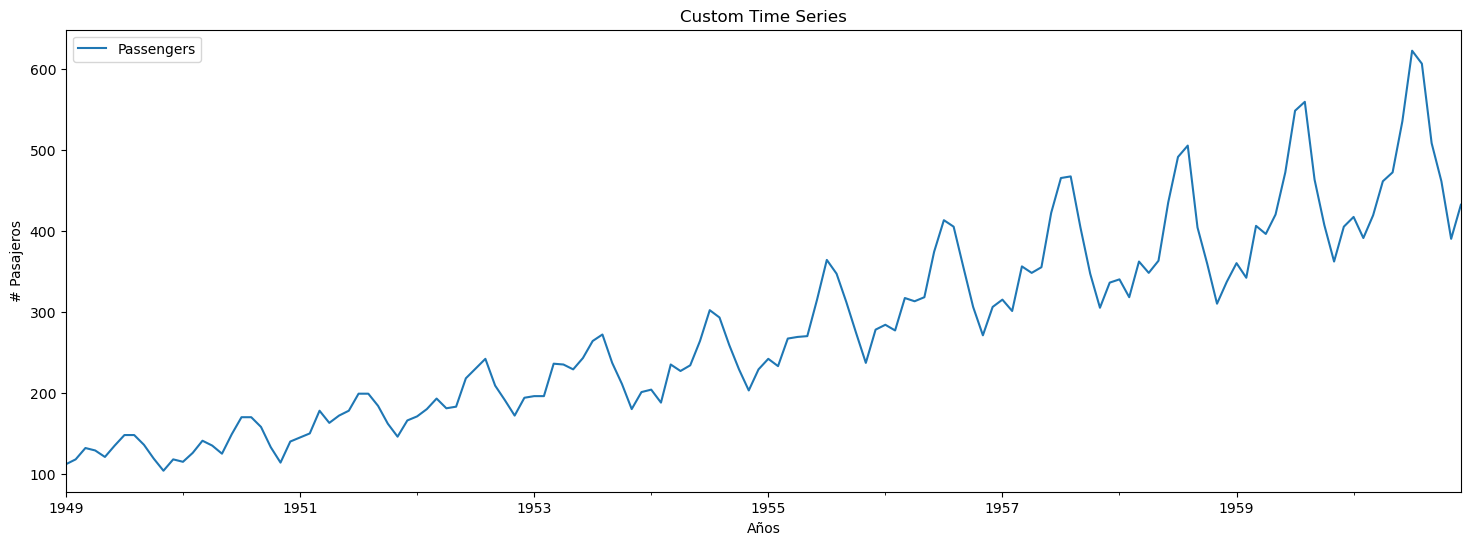

In [3]:
# Cargamos el dataset
real = pd.read_csv('data/AirPassengers.csv', header = 0, parse_dates = [0], names = ['Month', 'Passengers'], index_col = 0)

ax = real.plot(figsize=(18,6), title='Custom Time Series');
ax.set_xlabel("Años");
ax.set_ylabel("# Pasajeros");

In [4]:
def splitSet(df, TEST_SIZE):
    
    # Train set
    train_full = df[:(int(len(df)*(1-TEST_SIZE)))]
    train = train_full[:(int(len(train_full)*(1-TEST_SIZE)))]

    # Validation set
    valid = train_full[(int(len(train_full)*(1-TEST_SIZE))):]

    # Test set
    test = df[(int(len(df)*(1-TEST_SIZE))):]

    return train, valid, test

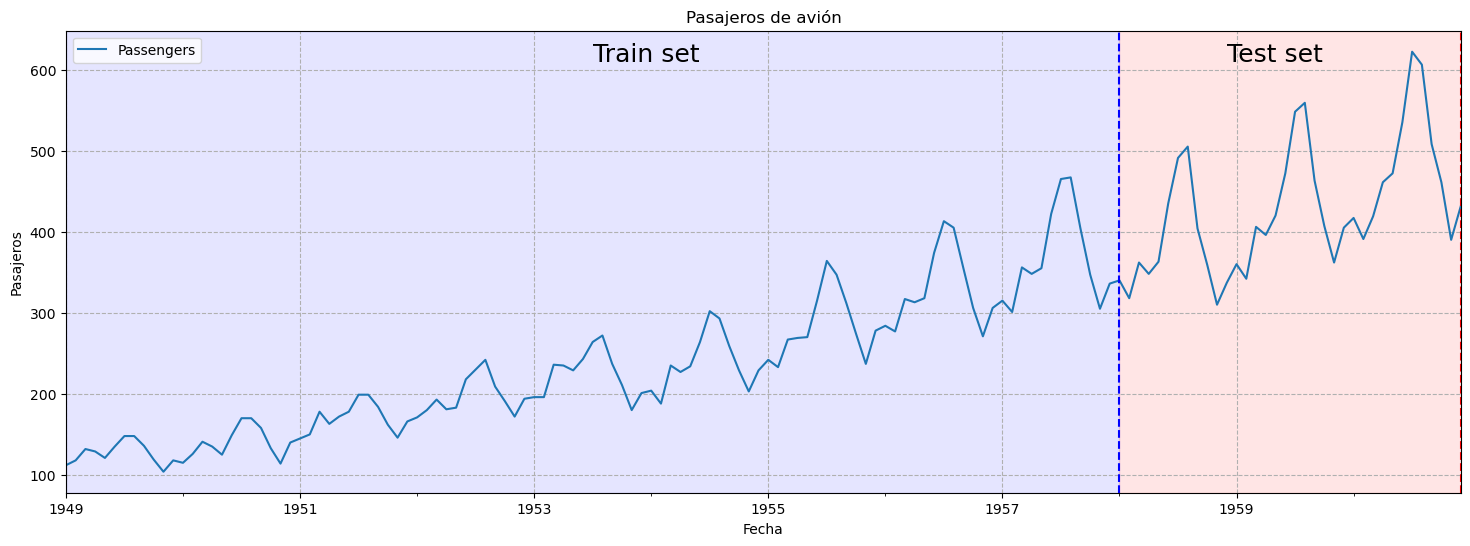

In [5]:
TEST_SIZE = 0.24
train, valid, test = splitSet(real, TEST_SIZE)

# Trabajamos sólo con train y test
train = pd.concat([train, valid], axis=0)

# Visualización
ax = real.plot(figsize=(18,6), title='Pasajeros de avión');

init__limit = real.index[0]
train_limit = real.index[len(train)-1]
test__limit = real.index[len(train)+len(test)-1]

ax.axvline(train_limit, linestyle='--', color='blue')
ax.axvline(test__limit, linestyle='--', color='red')

ax.axvspan(init__limit, train_limit, alpha=0.1, color='blue')
ax.axvspan(train_limit, test__limit, alpha=0.1, color='red')

ax.text(real.index[int((len(train)-1)*0.5)], 610, 'Train set', fontsize=18)
ax.text(real.index[int(len(train)+(len(test)-1)*0.3)], 610, 'Test set', fontsize=18)

ax.grid(linestyle='--')

ax.set_xlabel("Fecha");
ax.set_ylabel("Pasajeros");

In [6]:
airPassMetrics = pd.DataFrame(columns=['Model', 'RMSE'])

## Probando SARIMA con (2,1,1), (0,0,0) y 12 de seasonality

C:\Users\eduar\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\eduar\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


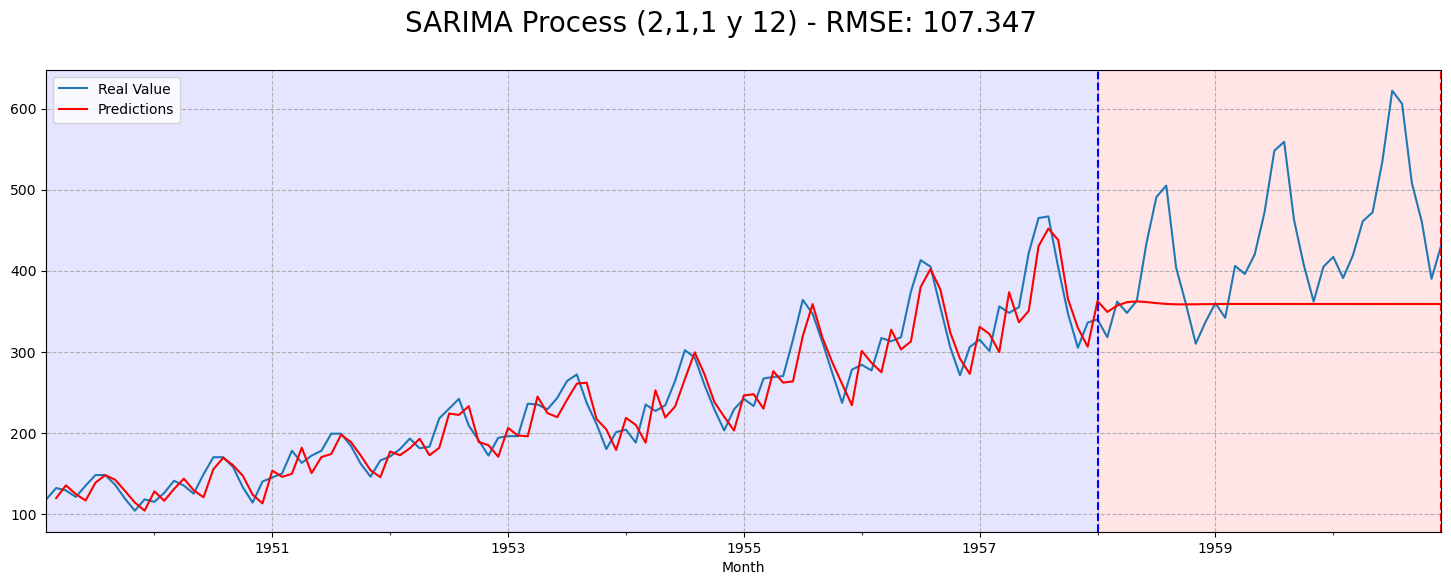

In [7]:
# Model
MODEL = 'SARIMA Process (2,1,1 y 12)'

# Coefficients
p=2
d=1
q=1
P=0
D=0
Q=0
m=12

trend_order = (p,d,q)
seasonal_order = (P,D,Q,m)

# Training model
model = SARIMAX(train, order = trend_order, seasonal_order = seasonal_order)
fitted_model = model.fit(disp=-1)
fitted_train = fitted_model.fittedvalues

# Get Test Set Predictions
predict_test = fitted_model.predict(test.index[0], test.index[len(test)-1])

# Get RMSE from Test Set
real_values = test['Passengers'][trend_order[1]:]
pred_values = predict_test[trend_order[1]:]
rmse = sqrt(mean_squared_error(real_values, pred_values))

# Get predictions from whole set
predictions = fitted_model.predict(real[trend_order[1]:].index[0], real[trend_order[1]:].index[len(real[trend_order[1]:])-1])[trend_order[1]:]

# Preparing data to plot
real_plot = real['Passengers'][trend_order[1]:]
pred_plot = predictions

# Visualization
figure(figsize=(18, 6))

real_plot.plot(label='Real Value')
pred_plot.plot(label='Predictions', color='red')
plt.suptitle(MODEL + ' - RMSE: ' + str(np.round(rmse, 3)), fontsize=20)
plt.legend();

plt.axvline(train_limit, linestyle='--', color='blue');
plt.axvline(test__limit, linestyle='--', color='red');

plt.axvspan(init__limit, train_limit, alpha=0.1, color='blue');
plt.axvspan(train_limit, test__limit, alpha=0.1, color='red');

plt.grid(linestyle='--')

metric_data = {'Model':MODEL, 'RMSE':np.round(rmse, 3)}
airPassMetrics = airPassMetrics.append(metric_data, ignore_index=True)

## Probando AutoARIMA

In [8]:
import pmdarima as pm

# Coefficients
auto_arima = pm.auto_arima(real, seasonal=True, m=12)
trend_order = auto_arima.order
seasonal_order = auto_arima.seasonal_order

print('ARIMA COEFFICIENTS:\n')
print('AR (p): ' + str(auto_arima.order[0]))
print('I (d): ' + str(auto_arima.order[1]))
print('MA (q): ' + str(auto_arima.order[2]))
print('Seasonal AR (P): ' + str(auto_arima.seasonal_order[0]))
print('Seasonal I (D): ' + str(auto_arima.seasonal_order[1]))
print('Seasonal MA (Q): ' + str(auto_arima.seasonal_order[2]))
print('Seasonal Order: ' + str(auto_arima.seasonal_order[3]))

ARIMA COEFFICIENTS:

AR (p): 2
I (d): 1
MA (q): 1
Seasonal AR (P): 0
Seasonal I (D): 1
Seasonal MA (Q): 0
Seasonal Order: 12


C:\Users\eduar\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\eduar\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


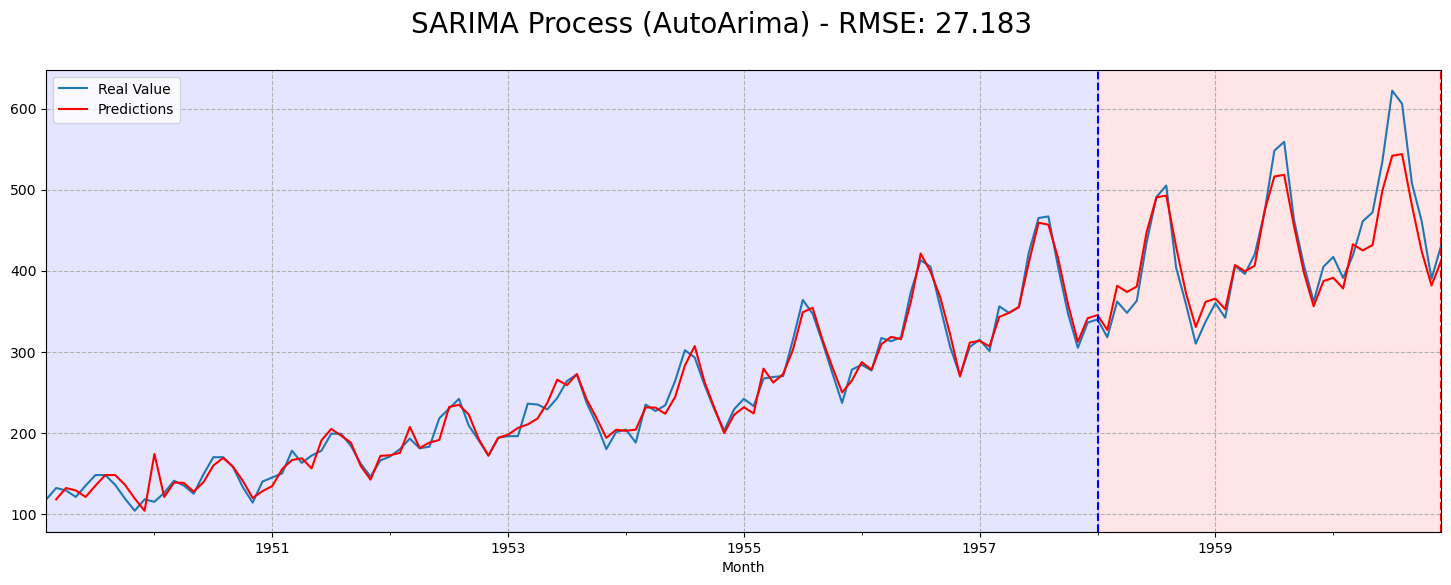

In [9]:
# Model
MODEL = 'SARIMA Process (AutoArima)'

# Training model
model = SARIMAX(train, order = auto_arima.order, seasonal_order = auto_arima.seasonal_order)
fitted_model = model.fit(disp=-1)
fitted_train = fitted_model.fittedvalues

# Get Test Set Predictions
predict_test = fitted_model.predict(test.index[0], test.index[len(test)-1])

# Get RMSE from Test Set
real_values = test['Passengers'][trend_order[1]:]
pred_values = predict_test[trend_order[1]:]
rmse = sqrt(mean_squared_error(real_values, pred_values))

# Get predictions from whole set
predictions = fitted_model.predict(real[trend_order[1]:].index[0], real[trend_order[1]:].index[len(real[trend_order[1]:])-1])[trend_order[1]:]

# Preparing data to plot
real_plot = real['Passengers'][trend_order[1]:]
pred_plot = predictions

# Visualization
figure(figsize=(18, 6))

real_plot.plot(label='Real Value')
pred_plot.plot(label='Predictions', color='red')
plt.suptitle(MODEL + ' - RMSE: ' + str(np.round(rmse, 3)), fontsize=20)
plt.legend();

plt.axvline(train_limit, linestyle='--', color='blue');
plt.axvline(test__limit, linestyle='--', color='red');

plt.axvspan(init__limit, train_limit, alpha=0.1, color='blue');
plt.axvspan(train_limit, test__limit, alpha=0.1, color='red');

plt.grid(linestyle='--')

metric_data = {'Model':MODEL, 'RMSE':np.round(rmse, 3)}
airPassMetrics = airPassMetrics.append(metric_data, ignore_index=True)

## Probando SARIMA con (0,1,1), (1,1,2) y 12 de seasonality

C:\Users\eduar\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\eduar\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


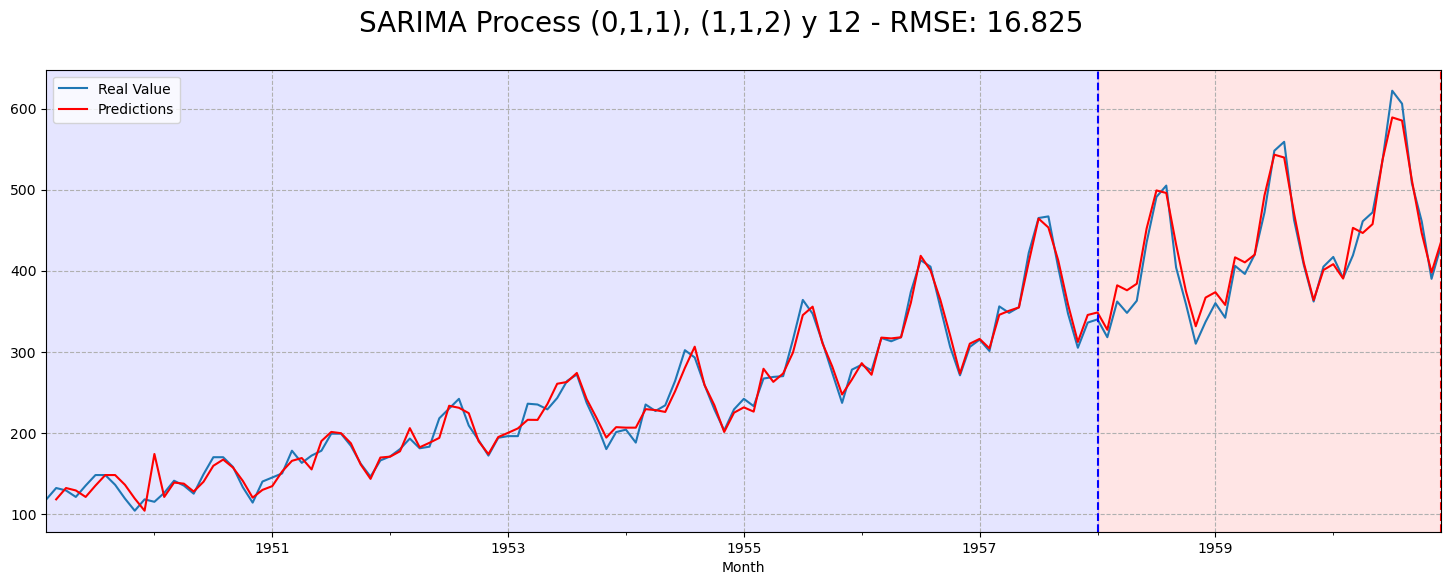

In [10]:
# Model
MODEL = 'SARIMA Process (0,1,1), (1,1,2) y 12'

# Coefficients
p=0
d=1
q=1
P=1
D=1
Q=2
m=12

trend_order = (p,d,q)
seasonal_order = (P,D,Q,m)

# Training model
model = SARIMAX(train, order = trend_order, seasonal_order = seasonal_order)
fitted_model = model.fit(disp=-1)
fitted_train = fitted_model.fittedvalues

# Get Test Set Predictions
predict_test = fitted_model.predict(test.index[0], test.index[len(test)-1])

# Get RMSE from Test Set
real_values = test['Passengers'][trend_order[1]:]
pred_values = predict_test[trend_order[1]:]
rmse = sqrt(mean_squared_error(real_values, pred_values))

# Get predictions from whole set
predictions = fitted_model.predict(real[trend_order[1]:].index[0], real[trend_order[1]:].index[len(real[trend_order[1]:])-1])[trend_order[1]:]

# Preparing data to plot
real_plot = real['Passengers'][trend_order[1]:]
pred_plot = predictions

# Visualization
figure(figsize=(18, 6))

real_plot.plot(label='Real Value')
pred_plot.plot(label='Predictions', color='red')
plt.suptitle(MODEL + ' - RMSE: ' + str(np.round(rmse, 3)), fontsize=20)
plt.legend();

plt.axvline(train_limit, linestyle='--', color='blue');
plt.axvline(test__limit, linestyle='--', color='red');

plt.axvspan(init__limit, train_limit, alpha=0.1, color='blue');
plt.axvspan(train_limit, test__limit, alpha=0.1, color='red');

plt.grid(linestyle='--')

metric_data = {'Model':MODEL, 'RMSE':np.round(rmse, 3)}
airPassMetrics = airPassMetrics.append(metric_data, ignore_index=True)

In [11]:
airPassMetrics.sort_values(by=['RMSE'], ascending=True)

,Model,RMSE
2,"SARIMA Process (0,1,1), (1,1,2) y 12",16.825
1,SARIMA Process (AutoArima),27.183
0,"SARIMA Process (2,1,1 y 12)",107.347
